### refs usadas:
- https://www.researchgate.net/publication/324929106_Dynamic_Models_of_a_Home_Refrigerator
- http://www.ingaero.uniroma1.it/attachments/2176_Cap_3%20Thermal-electrical%20analogy.pdf
- https://www.engineeringtoolbox.com/heat-work-energy-d_292.html
- https://economizandoenergia.wordpress.com/2011/12/11/hackeando-a-geladeira/

### refs não usadas, mas interessantes:
- https://www.researchgate.net/publication/269930557_Temperature_control_in_a_cavity_of_refrigeration_using_PI_controller_and_predictive_control
- http://greenteapress.com/modsimpy/ModSimPy3.pdf


#### Breve revisão de calor no ponto de vista energético:
- Para aquecer um corpo de massa $m$ de calor específico $c_p$ em diferença de temperatura $dT$ é necessário o calor $Q$ (em _Joules_), de modo que:
$$ Q = c_p\,m\,dT $$
- A potência (em _Watts_) necessária para aquecer o mesmo corpo em um intervalo de tempo $t$ é:
$$ q = Q / t $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_freezer_unit(sensor_id: int, verbose=False):
    """ consumo médio de um congelador:
    ref:  http://www.procelinfo.com.br/services/DocumentManagement/FileDownload.EZTSvc.asp?DocumentID={8898769E-E9B6-4AB9-A509-CCAFE715310F}&ServiceInstUID={46764F02-4164-4748-9A41-C8E7309F80E1}
    modelo: RCFB32
    compartimento: 385 Litros
    consumo: 35.9 kwh/mês

    ref:  https://www.mideastore.com.br/media/productattach/m/a/manual_do_usu_rio_3.pdf
    Corrente nominal de operação em 220V: 1.6A
    
    # Parece ok, resultados proximos de: https://economizandoenergia.wordpress.com/tag/freezer/
    """
    E_monthly = 35.9e3 * (0.95 + 0.05 * np.random.rand()) # adicionando uma variação para as unidades
    E_anualy = E_monthly * 12
    hours_per_year = 8760
    E_hourly = E_anualy / hours_per_year
    E_daily = E_hourly * 24
    E_minutely = E_hourly / 60
    E_secondly = E_minutely / 60
    # print(E_anualy, E_monthly, E_daily, E_hourly, E_minutely, E_secondly)

    # Estimativas para fechar com os dados de catálogo:
    I_nominal = 1.6 * (0.8 + 0.2 * np.random.rand()) # adicionando uma variação para as unidades
    P_nominal = 220 * I_nominal
    P_nominal_avg = 250
    on_to_off_factor = P_nominal_avg / P_nominal
    P_on = 220 * I_nominal * on_to_off_factor 
    P_off = 220 * I_nominal * (1 - on_to_off_factor)
    if verbose:
        print(f"P nominal = {P_nominal} W")
        print(f"Pon = {P_on} W")
        print(f"Poff = {P_off} W")
        print(f"Check: {P_nominal == P_on + P_off}")

    t_daily = 24.0
    P_daily = E_daily / t_daily
    t_on = t_daily * (P_daily - P_off) / (P_off - P_on)
    t_off = t_daily - t_on
    duty_cycle = t_on / t_daily
    if verbose:
        print(f"daily total: P = {P_daily} W, t = {t_daily} h")
        print(f"daily on: P = {P_on} W, t = {t_on} h")
        print(f"daily off: P = {P_off} W, t = {t_off} h")
        print(f"duty cycle: {duty_cycle * 100} %")
        print(f"Check: {t_daily == t_on + t_off}")
        
    return {
        'sensor_id': sensor_id,
        'model': 'RCFB32',
        'volume': 385,
        'E_monthly': E_monthly,
        'E_anualy': E_anualy,
        'E_hourly': E_hourly,
        'E_daily': E_daily,
        'E_minutely': E_minutely,
        'E_secondly': E_secondly,
        'I_nominal': I_nominal,
        'P_nominal': P_nominal,
        'P_nominal_avg': P_nominal_avg,
        'on_to_off_factor': on_to_off_factor,
        'P_on': P_on,
        'P_off': P_off,
        't_daily': t_daily,
        'P_daily': P_daily,
        't_on': t_on,
        't_off': t_off,
        'duty_cycle': duty_cycle,
    }

print("EXAMPLE:\n")
example = generate_freezer_unit(0,verbose=True)
display(example)

EXAMPLE:

P nominal = 318.2815398558948 W
Pon = 250.0 W
Poff = 68.28153985589476 W
Check: True
daily total: P = 47.3346268559627 W, t = 24.0 h
daily on: P = 250.0 W, t = 2.766509861462071 h
daily off: P = 68.28153985589476 W, t = 21.233490138537928 h
duty cycle: 11.527124422758629 %
Check: True


{'sensor_id': 0,
 'model': 'RCFB32',
 'volume': 385,
 'E_monthly': 34554.277604852774,
 'E_anualy': 414651.3312582333,
 'E_hourly': 47.3346268559627,
 'E_daily': 1136.0310445431048,
 'E_minutely': 0.7889104475993783,
 'E_secondly': 0.013148507459989639,
 'I_nominal': 1.446734272072249,
 'P_nominal': 318.2815398558948,
 'P_nominal_avg': 250,
 'on_to_off_factor': 0.7854681113871388,
 'P_on': 250.0,
 'P_off': 68.28153985589476,
 't_daily': 24.0,
 'P_daily': 47.3346268559627,
 't_on': 2.766509861462071,
 't_off': 21.233490138537928,
 'duty_cycle': 0.11527124422758629}

# Abrindo banco de dados de temperaturas de florianópolis

,ta
timestamp,
2019-01-01 01:00:00,26.9
2019-01-01 02:00:00,26.6
2019-01-01 03:00:00,26.4
2019-01-01 04:00:00,26.5
2019-01-01 05:00:00,26.5
...,...
2019-12-31 19:00:00,29.3
2019-12-31 20:00:00,28.0
2019-12-31 21:00:00,27.2


,ta
count,8751.000000
mean,21.815987
std,4.298974
min,5.100000
25%,19.200000
50%,21.900000
75%,24.600000
max,39.300000


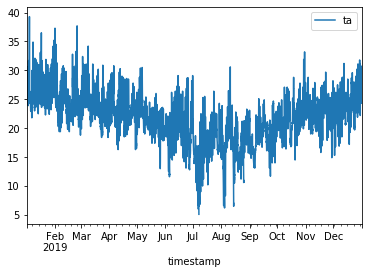

In [2]:
ta_df = pd.read_csv(
    'data/ambient_temperature_hourly.csv',
    header=10,
    date_parser=pd.to_datetime,
    names=['timestamp', 'ta'],
    index_col='timestamp',
)
display(ta_df)
display(ta_df.describe())
ta_df.plot()

# Gerando o perfil termico de alta frequencia

In [3]:
from scipy import signal

def get_sinal_profile(duty_cycle, samples_per_period, noise_level=0.05):
#     triangle = (1 -signal.sawtooth(2 * np.pi * freq * time, width=duty_cycle))*0.5
    freq = 1
    time = np.arange(0, 1, 1/samples_per_period)
    
    l = int(len(time)*duty_cycle)
    exp = time * 0
    exp[:l] = 1 -np.exp(time / 0.09)[len(time)-l:]
    exp[:l] /= max(abs(exp))
    exp[:l] += 1
    exp[l:] = 0.1*np.exp(time / 0.2)[l:] -1
    exp[l:] /= max(abs(exp[l:]))
    exp -= min(exp)
    exp /= max(exp)
    return (1-noise_level)*exp + noise_level*(1 -np.random.rand(len(exp)))

def generate_signal(sensor, days, verbose=False, plot=False):

    # 60 samples por 10 minutos = 600 samples
    samples = 600
    profile = get_sinal_profile(sensor['duty_cycle'], samples_per_period=samples)

    # 1 dia tem 24 * 60 minutos, se temos 1  ciclo a cada 10 minutos, temos 24 * 60 / 10 para 1 dia
    cycles = int(days * 24 * 60 / 10)
    df_ti = pd.DataFrame(
        index=pd.date_range(start='2020-01-01 00:00:00', periods=cycles*samples, freq='s'),
        data={'ti': np.tile(profile, cycles)}
    )
    if verbose:
        display(df_ti)

    if plot:
        plt.figure(figsize=(50,10))
        plt.plot(df_ti);  # 1 seg
        plt.plot(df_ti.resample('1T').mean())  # 1 min
        plt.plot(df_ti.resample('2.5T').mean())  # 2.5 min
        plt.plot(df_ti.resample('5T').mean())  # 5 min
        
    return df_ti
    
# generate_signal(example, days=1, verbose=True, plot=True)

# agora podemos multiplicar esse formato pela temperatura interna média de um dataset de menor frequência

# Gerando os dados do sensor

In [4]:
voltage = 220 + (np.random.rand(len(ta_df)) * 5 - 2.5)
basic_energy_tariff = 0.50599 * (1 + 0.25)  # Tarifa residencial B da celesc + aliquota: 12% se menor que 150kWh, 25% se maior.

def generate_sensor_dataframe(df, sensor: dict, verbose=False, plot=False):
    days = len(df)
    df['E'] = (0.6 + 0.4*np.random.rand(len(df))) * sensor['E_hourly'] * df['ta'] / df['ta'].mean() / 1000 # kwh
    df['cost'] = df['E'].cumsum() * basic_energy_tariff
    df['P'] = 1000 * df['E'] / 1 # watts
    df['V'] = voltage + 0.1 * np.random.rand(len(df))
    df['I'] = df['P'] / df['V']
    df['ti'] = 4 + np.random.rand(len(df)) + 0.5*df['ta'].rolling(500, win_type='blackman', center=True, min_periods=1).mean() -10

    df = df.resample('1s').interpolate(method='time')
    display(df.head())
    print(len(df))

    hf_ti = generate_signal(sensor, days=365)
    df['ti'] = df['ti'] * hf_ti['ti']
#     df.index = df_ti.index

    df = df.rename(columns={
        "ta": "ambiente_temperature",
        "ti": "internal_temperature",
        "V": "voltage",
        "I": "current",
        "P": "active_power",
        "E": "energy",
        "cost": "cost",
    })
#     if verbose:
#         display(df.describe())
#     if plot:
#         plt.Figure(figsize=(20, 10))
#         plt.plot(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
# #         plot_multi(df.rolling(25, win_type='blackman', center=True, min_periods=1).mean())
#         plt.show()
    
    output_filename = f"data/hf_0_sensor_{int(sensor['sensor_id'])}_db.csv"
    df.to_csv(output_filename)
    print(f"Done: the data for the sensor id {sensor['sensor_id']} was saved to: {output_filename}")
    del df

for sensor_id in [0]:
    sensor = generate_freezer_unit(sensor_id)
    generate_sensor_dataframe(ta_df.copy(), sensor, verbose=True, plot=True)

,ta,E,cost,P,V,I,ti
timestamp,,,,,,,
2019-01-01 01:00:00,26.900000,0.037133,0.023486,37.133337,218.942949,0.169603,8.043987
2019-01-01 01:00:01,26.899917,0.037134,0.023493,37.133505,218.943620,0.169603,8.044073
2019-01-01 01:00:02,26.899833,0.037134,0.023500,37.133673,218.944291,0.169603,8.044158
2019-01-01 01:00:03,26.899750,0.037134,0.023506,37.133840,218.944962,0.169604,8.044244
2019-01-01 01:00:04,26.899667,0.037134,0.023513,37.134008,218.945633,0.169604,8.044330


31528801
Done: the data for the sensor id 0 was saved to: data/hf_0_sensor_0_db.csv
